### **BPIC 2017 - No milestone**


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical


### Define the experiment parameters

In [3]:
milestone = 'All' #'A_PREACCEPTED' # 'W_Nabellen offertes', 'All'
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
n_size = 5
max_size = 1000 #  3, 5, 10, 15, 20, 30, 50, 95
min_size = 0  # 0, 3, 5, 10, 15, 20, 30, 50

### Setting up the key parameters


In [4]:
# # For local environment only

MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC17')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [5]:
args = get_parameters('bpic17', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)
args

{'folder': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\All\\OHE\\output_files',
 'lstm_act': None,
 'dense_act': None,
 'optim': 'Adam',
 'norm_method': 'lognorm',
 'model_type': 'shared_cat',
 'l_size': 50,
 'n_size': 5,
 'file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\BPIC_2017_Prefixes.csv',
 'file_name_all': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\BPIC_2017_Prefixes_all.csv',
 'processed_file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\All\\OHE\\BPIC_2017_Processed.csv',
 'processed_training_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\All\\OHE\\vec_training.p',
 'processed_test_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Att

In [6]:
#This code will be specific for all next activity prediction only, since we save the models and vectors by prefix length groups
if milestone == 'All':
  args['indexes'] = MILESTONE_DIR+'indexes_'+str(max_size)+'.p'
  args['pre_index'] = MILESTONE_DIR+'pre_index_'+str(max_size)+'.p'
  args['processed_test_vec'] = MILESTONE_DIR+'vec_test_'+str(max_size)+'.p'
  args['processed_training_vec'] = MILESTONE_DIR+'vec_training_'+str(max_size)+'.p'
  args['weights'] = MILESTONE_DIR+'weights_'+str(max_size)+'.p'

args

{'folder': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\All\\OHE\\output_files',
 'lstm_act': None,
 'dense_act': None,
 'optim': 'Adam',
 'norm_method': 'lognorm',
 'model_type': 'shared_cat',
 'l_size': 50,
 'n_size': 5,
 'file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\BPIC_2017_Prefixes.csv',
 'file_name_all': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\BPIC_2017_Prefixes_all.csv',
 'processed_file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\All\\OHE\\BPIC_2017_Processed.csv',
 'processed_training_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC17\\All\\OHEvec_training_1000.p',
 'processed_test_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Shared-and-Specialised-

###Data Preprocessing

In [7]:
if milestone == 'All':
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)
else:
  log_df = pd.read_csv(args['file_name'])
  log_df = log_df.reset_index(drop=True)

log_df.head()

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,prefix_length,timelapsed_2
0,Application_1000311556_10,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,W_Call after offers,O_Cancelled,10,1,10,0
1,Application_1000311556_1,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,W_Complete application,A_Create Application,1,1,1,0
2,Application_1000311556_7,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,A_Complete,O_Sent (mail and online),7,1,7,0
3,Application_1000311556_6,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,O_Sent (mail and online),O_Created,6,1,6,0
4,Application_1000311556_9,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,O_Cancelled,A_Cancelled,9,1,9,0


Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [8]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]
else:
  log_df = log_df[(log_df['prefix_length'] > min_size) & (log_df['prefix_length'] <= max_size) ]

#### Data Analysis

In [9]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
A_Accepted                  10000
A_Cancelled                  3338
A_Complete                   9947
A_Concept                   10000
A_Denied                     1217
A_Incomplete                 7341
A_Pending                    5421
A_Submitted                  6452
A_Validating                12371
O_Accepted                   5421
O_Cancelled                  6667
O_Create Offer              13625
O_Created                   13625
O_Refused                    1501
O_Returned                   7376
O_Sent (mail and online)    12573
O_Sent (online only)          640
W_Assess potential fraud       90
W_Call after offers         10973
W_Call incomplete files      7330
W_Complete application      10013
W_Handle leads               6461
W_Validate application      12417
Name: prefix_id, dtype: int64


We can see that there is an imbalance in the dataset, by the next activity name, as well as a very high dimensionality in the target variable.
Therefore, we can reduce the imbalance and high dimensionality of data by grouping some of the activity name.


Balancing the dataset


In [10]:
def balance(df):
  # Dictonary with the mapping of columns
  
  #based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  # group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
  #   'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
  #   'A_APPROVED':  'A_APPROVED_ACTIVATED',
  #   'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
  #   'A_DECLINED': 'A_CANCELLED_DECLINED' ,
  #   'A_PARTLYSUBMITTED': 'REDUNDANT',
  #   'A_PREACCEPTED':'A_PREACCEPTED',
  #   'A_REGISTERED' : 'REDUNDANT',
  #   'O_ACCEPTED' : 'REDUNDANT',
  #   'O_CANCELLED' :  'O_CANCELLED_DECLINED' ,
  #   'O_CREATED':'REDUNDANT',
  #   'O_DECLINED' :'O_CANCELLED_DECLINED' ,
  #   'O_SELECTED' : 'REDUNDANT', 
  #   'O_SENT':'O_SENT',
  #   'O_SENT_BACK' : 'O_SENT_BACK',
  #   'W_Afhandelen leads' :  'W_Afhandelen leads',
  #   'W_Completeren aanvraag': 'W_Completeren aanvraag',
  #   'W_Nabellen incomplete dossiers':'W_Nabellen incomplete dossiers',
  #   'W_Nabellen offertes':'W_Nabellen offertes',
  #   'W_Valideren aanvraag' : 'W_Valideren aanvraag'}


  # df['next_activity'].replace(group_dict, inplace=True)
  # #Dropping the minority classes
  # df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

In [11]:
log_df = balance(log_df)



#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

In [12]:
# Check the balance

print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
A_Accepted                  10000
A_Cancelled                  3338
A_Complete                   9947
A_Concept                   10000
A_Denied                     1217
A_Incomplete                 7341
A_Pending                    5421
A_Submitted                  6452
A_Validating                12371
O_Accepted                   5421
O_Cancelled                  6667
O_Create Offer              13625
O_Created                   13625
O_Refused                    1501
O_Returned                   7376
O_Sent (mail and online)    12573
O_Sent (online only)          640
W_Assess potential fraud       90
W_Call after offers         10973
W_Call incomplete files      7330
W_Complete application      10013
W_Handle leads               6461
W_Validate application      12417
Name: prefix_id, dtype: int64


In [13]:

#minority reduction. if certain samples are < 5, reduce via below

#log_df = log_df.drop(log_df[log_df.next_activity == 'W_Afhandelen leads'].index)



Reduce Loops

Function : `reduce_loops(df)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [14]:
if experiment == 'No_Loops':
  log_df = reduce_loops(log_df)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [15]:
# Index creation for activity

ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit

rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity

ne_index = create_index(log_df, 'next_activity')

index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

print(rl_index)
print(index_rl)
log_df.head()

{'none': 0, 'User_1': 1, 'User_10': 2, 'User_100': 3, 'User_101': 4, 'User_102': 5, 'User_103': 6, 'User_104': 7, 'User_105': 8, 'User_106': 9, 'User_107': 10, 'User_108': 11, 'User_109': 12, 'User_11': 13, 'User_110': 14, 'User_111': 15, 'User_112': 16, 'User_113': 17, 'User_114': 18, 'User_115': 19, 'User_116': 20, 'User_117': 21, 'User_118': 22, 'User_119': 23, 'User_12': 24, 'User_120': 25, 'User_121': 26, 'User_122': 27, 'User_123': 28, 'User_124': 29, 'User_125': 30, 'User_126': 31, 'User_127': 32, 'User_128': 33, 'User_129': 34, 'User_13': 35, 'User_130': 36, 'User_131': 37, 'User_132': 38, 'User_133': 39, 'User_134': 40, 'User_135': 41, 'User_136': 42, 'User_137': 43, 'User_138': 44, 'User_139': 45, 'User_14': 46, 'User_140': 47, 'User_141': 48, 'User_142': 49, 'User_143': 50, 'User_144': 51, 'User_15': 52, 'User_16': 53, 'User_17': 54, 'User_18': 55, 'User_19': 56, 'User_2': 57, 'User_20': 58, 'User_21': 59, 'User_22': 60, 'User_23': 61, 'User_24': 62, 'User_25': 63, 'User_26'

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,prefix_length,timelapsed_2,ac_index,rl_index,ne_index
0,Application_1000311556_10,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,W_Call after offers,O_Cancelled,10,1,10,0,5,114,18
1,Application_1000311556_1,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,W_Complete application,A_Create Application,1,1,1,0,5,114,20
2,Application_1000311556_7,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,A_Complete,O_Sent (mail and online),7,1,7,0,5,114,2
3,Application_1000311556_6,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,O_Sent (mail and online),O_Created,6,1,6,0,5,114,15
4,Application_1000311556_9,Application_1000311556,A_Create Application,User_71,2016-04-05 01:56:37.6750000,2016-04-05 01:56:37.6750000,0,O_Cancelled,A_Cancelled,9,1,9,0,5,114,10


In [16]:
print(ne_index)

{'A_Accepted': 0, 'A_Cancelled': 1, 'A_Complete': 2, 'A_Concept': 3, 'A_Denied': 4, 'A_Incomplete': 5, 'A_Pending': 6, 'A_Submitted': 7, 'A_Validating': 8, 'O_Accepted': 9, 'O_Cancelled': 10, 'O_Create Offer': 11, 'O_Created': 12, 'O_Refused': 13, 'O_Returned': 14, 'O_Sent (mail and online)': 15, 'O_Sent (online only)': 16, 'W_Assess potential fraud': 17, 'W_Call after offers': 18, 'W_Call incomplete files': 19, 'W_Complete application': 20, 'W_Handle leads': 21, 'W_Validate application': 22}


Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [17]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [18]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)


In [19]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())


print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))


Number of traces in training set is:122359
Number of traces in test set is:52440


In [20]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['next_activity'])['prefix_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['next_activity'])['prefix_id'].nunique())
print("")



training dataset
next_activity
A_Accepted                  7328
A_Cancelled                 2356
A_Complete                  7057
A_Concept                   7360
A_Denied                     820
A_Incomplete                4806
A_Pending                   3698
A_Submitted                 4824
A_Validating                8307
O_Accepted                  3723
O_Cancelled                 4483
O_Create Offer              9701
O_Created                   9613
O_Refused                    996
O_Returned                  5049
O_Sent (mail and online)    8868
O_Sent (online only)         403
W_Assess potential fraud      60
W_Call after offers         7714
W_Call incomplete files     4762
W_Complete application      7301
W_Handle leads              4785
W_Validate application      8345
Name: prefix_id, dtype: int64

test dataset
next_activity
A_Accepted                  2672
A_Cancelled                  982
A_Complete                  2890
A_Concept                   2640
A_Denied            

Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [21]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)
#log_val = reformat_events(log_df_val, ac_index, rl_index,ne_index)

#print a sample of the dictionary
print(log_train[100])

{'caseid': 'Application_1010825982_17', 'ac_order': [11, 10, 21, 7, 24, 16, 10, 20, 20, 3, 22, 17, 14, 13, 1, 4, 5], 'rl_order': [118, 37, 37, 12, 12, 17, 17, 17, 44, 98, 98, 98, 98, 98, 98, 81, 81], 'tbtw': [1.4508463259773585, 1.4478182121455467, 1.4478182121455467, 1.399506361189634, 1.399506361189634, 1.2334598805039754, 1.2334598805039754, 1.2334598805039754, 1.2334598805039754, 0.6225553419798194, 0.6225553419798194, 0.6225553419798194, 0.6225553419798194, 0.6225553419798194, 0.6225553419798194, -1.0297735775238088, -1.0297735775238088], 'next_activity': 6}


Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [22]:
#Obtain the maximum trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)
#trc_len_val, cases_val = lengths(log_val)

trc_len = max([trc_len_train, trc_len_test])

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 57, training cases: 122360, test cases: 52441


converting the training log (dictionary) into a Tensor

In [23]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)
#vec_val = vectorization(log_val,ac_index, rl_index, ne_index,trc_len,cases_val)

In [24]:
vec_train['prefixes']['x_ac_inp']

array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3., 22., 17., ...,  0.,  0.,  0.],
       ...,
       [14., 13.,  1., ...,  0.,  0.,  0.],
       [17., 14., 13., ...,  0.,  0.,  0.],
       [22., 17., 14., ...,  0.,  0.,  0.]])

#### Generating Initial Embedding Weights for Shared Model

In [25]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0


#### Saving the Processed Tensor and Other Support Data

In [27]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_training_vec'])

if not os.path.exists(dirname):
    os.makedirs(dirname)

with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)


# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}
with open(args['pre_index'], 'wb') as fp:
    pickle.dump(pre_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Experiments

#### Load the Required Libraries

In [28]:
!pip3 install pyflowchart

In [29]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### Load the Required Parameters

In [30]:
#with open(os.path.join(MILESTONE_DIR,'args.p'), 'rb') as fp:
    #args = pickle.load(fp)

with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
next_activity = weights['next_activity']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    index_ne = indexes['index_ne']

with open(args['pre_index'], 'rb') as fp:
    pre_index = pickle.load(fp)
    ac_index = pre_index['ac_index']
    rl_index = pre_index['rl_index']
    ne_index = pre_index['ne_index']

#### Shared Model

In [31]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

In [32]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
ac_embedding (Embedding)        (None, 5, 25)        625         ac_input[0][0]                   
__________________________________________________________________________________________________
rl_embedding (Embedding)        (None, 5, 145)       21025       rl_input[0][0]                   
______________________________________________________________________________________________

In [33]:
batch_size = 128 # 32, 64, 128, 256
epochs = 200

In [34]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/200
813/813 [==============================] - 42s 31ms/step - loss: 1.1237 - accuracy: 0.6917 - val_loss: 0.5441 - val_accuracy: 0.8030
Epoch 2/200
813/813 [==============================] - 25s 31ms/step - loss: 0.5157 - accuracy: 0.8125 - val_loss: 0.4647 - val_accuracy: 0.8217
Epoch 3/200
813/813 [==============================] - 25s 31ms/step - loss: 0.4613 - accuracy: 0.8256 - val_loss: 0.4376 - val_accuracy: 0.8305
Epoch 4/200
813/813 [==============================] - 24s 30ms/step - loss: 0.4383 - accuracy: 0.8307 - val_loss: 0.4276 - val_accuracy: 0.8309
Epoch 5/200
813/813 [==============================] - 26s 31ms/step - loss: 0.4231 - accuracy: 0.8344 - val_loss: 0.4171 - val_accuracy: 0.8351
Epoch 6/200
813/813 [==============================] - 25s 30ms/step - loss: 0.4117 - accuracy: 0.8366 - val_loss: 0.4103 - val_accuracy: 0.8366
Epoch 7/200
813/813 [==============================] - 25s 31ms/step - loss: 0.4051 - accuracy: 0.8382 - val_loss: 0.4070 - val_ac

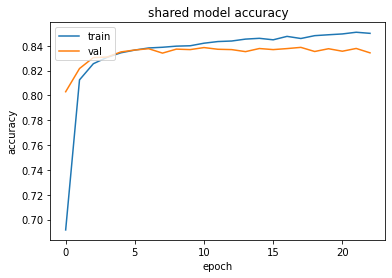

In [35]:
plot_shared(shared_history)

In [36]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared.save(trained_model)

##### Load Saved Model and Evaluate

In [37]:
shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared_model = load_model(shared_trained_model)

In [38]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared_model.evaluate(x_test, y_test, batch_size=batch_size)
y_pred_shared = shared_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
410/410 [==============================] - 6s 12ms/step - loss: 0.4371 - accuracy: 0.8286
test loss, test acc: [0.43707773089408875, 0.828569233417511]


In [39]:
m1_y_test = y_test.argmax(axis=1)
m1_y_pred = y_pred_shared.argmax(axis=1)

Classification Report

In [40]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                          precision    recall  f1-score   support

              A_Accepted       0.99      0.69      0.81      2672
             A_Cancelled       0.32      0.05      0.08       982
              A_Complete       0.93      0.95      0.94      2890
               A_Concept       0.97      0.85      0.91      2640
                A_Denied       0.32      0.03      0.06       397
            A_Incomplete       0.75      0.89      0.82      2535
               A_Pending       1.00      1.00      1.00      1723
             A_Submitted       1.00      1.00      1.00      1628
            A_Validating       0.81      0.81      0.81      4064
              O_Accepted       0.46      0.50      0.48      1698
             O_Cancelled       0.96      0.83      0.89      2184
          O_Create Offer       0.98      0.71      0.82      3924
               O_Created       1.00      1.00      1.00      4012
               O_Refused       0.98      0.86      0.91       505
         

Confusion Matrix

[[1842    0    0    0    0    0    0    1    0    0    0    1    0    0
     0    0    0    0    0    0  828    0    0]
 [   0   45    1    0    1    0    0    0   21   10    5   19    0    0
     7    8    0    0  776   76    5    0    8]
 [   0    0 2739    0    0    0    0    0    0    0    0    0    0    0
     0   31    0    0    2    0  118    0    0]
 [   0    0    0 2239    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  401    0    0]
 [   0    3    0    0   13  102    0    0    6  106    1    5    0    0
     9    1    0    0    4   19    0    0  128]
 [   0    0    0    0    8 2251    0    0    2  200    0    0    0    0
    39    0    0    0    0    3    0    0   32]
 [   0    0    0    0    0    0 1723    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1628    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    4    0    

<AxesSubplot:>

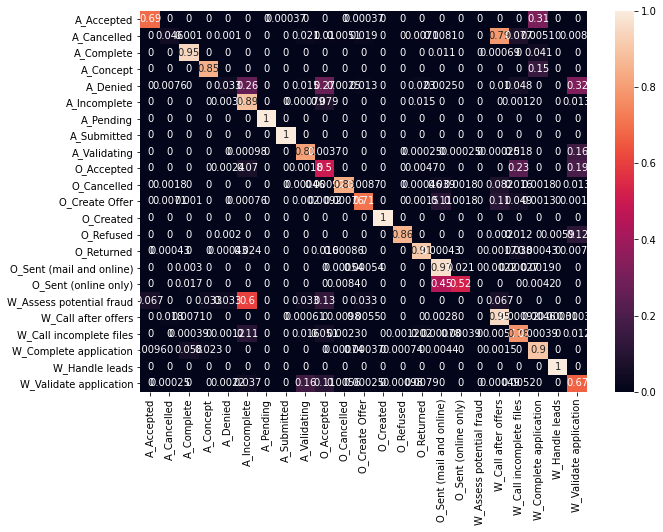

In [41]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

#### specialised Model

In [47]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


In [48]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [49]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 5, 25)]      0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 5, 145)]     0                                            
__________________________________________________________________________________________________
t_input (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
beta_ac (Bidirectional)         (None, 5, 100)       30400       ac_input[0][0]                   
____________________________________________________________________________________________

In [50]:
batch_size = 128 # 32, 64, 128, 256
epochs = 200

In [51]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  c:\Users\mithr\Documents\GitHub\Shared-and-Specialised-Attention-based-Interpretable-Models\BPIC17\models\model_specialised_All_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/200
813/813 [==============================] - 30s 29ms/step - loss: 2.2101 - accuracy: 0.3879 - val_loss: 1.6384 - val_accuracy: 0.5386
Epoch 2/200
813/813 [==============================] - 21s 26ms/step - loss: 1.4991 - accuracy: 0.5161 - val_loss: 1.2872 - val_accuracy: 0.5843
Epoch 3/200
813/813 [==============================] - 21s 26ms/step - loss: 1.2951 - accuracy: 0.5454 - val_loss: 1.0976 - val_accuracy: 0.6315
Epoch 4/200
813/813 [==============================] - 21s 26ms/step - loss: 1.1229 - accuracy: 0.6058 - val_loss: 0.9215 - val_accuracy: 0.6868
Epoch 5/200
813/813 [==============================] - 21s 26ms/step - loss: 1.0148 - accuracy: 0.6328 - val_loss: 0.8316 - val_accuracy: 0.7044
Epoch 6/200
813/813 [==============================] - 21s 26ms/step - loss: 0.9491 - a

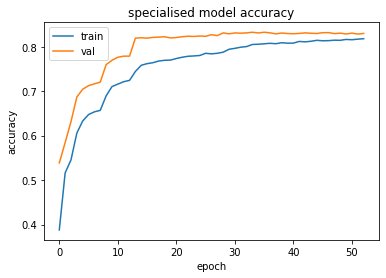

In [52]:
plot_specialised(specialised_history)

In [53]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model_'+str(max_size)+'.h5')
specialised.save(trained_model)

##### Load Saved Model and Evaluate

In [54]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model_'+str(max_size)+'.h5')
specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [55]:
# Generating Inputs

x_test,y_test = generate_inputs(vec_test,args,indexes, experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised_model.evaluate(x_test, y_test, batch_size=batch_size)
y_pred = specialised_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
410/410 [==============================] - 8s 16ms/step - loss: 0.4829 - accuracy: 0.8206
test loss, test acc: [0.48288384079933167, 0.8205602765083313]


In [56]:
m2_y_test = y_test.argmax(axis=1)
m2_y_pred = y_pred.argmax(axis=1)

In [57]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.98      0.85      2672
           1       0.29      0.01      0.02       982
           2       0.90      0.95      0.93      2890
           3       0.91      0.91      0.91      2640
           4       0.28      0.02      0.03       397
           5       0.75      0.86      0.80      2535
           6       1.00      1.00      1.00      1723
           7       1.00      1.00      1.00      1628
           8       0.78      0.87      0.82      4064
           9       0.41      0.43      0.42      1698
          10       0.97      0.82      0.89      2184
          11       0.96      0.70      0.81      3924
          12       1.00      1.00      1.00      4012
          13       0.95      0.85      0.90       505
          14       0.91      0.91      0.91      2327
          15       0.82      0.98      0.89      3705
          16       0.63      0.31      0.41       237
          17       0.00    

Confusion Matrix

[[2626    0    1    0    2    0    0    0    0    0    0    2    0    0
     0    0    0    0    0    0   41    0    0]
 [   0   12    6    0    0    0    0    0   19   32    1   21    0    0
     4   20    0    0  801   59    0    0    7]
 [   0    0 2755    0    0    0    0    0    3    0    0    0    0    0
     0   33    0    0    4    0   95    0    0]
 [   2    0    1 2402    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  235    0    0]
 [   0    1    0    0    7  100    0    0    4   99    0    2    0    0
     9    1    0    0    9   17    1    0  147]
 [   0    0    0    0    2 2186    0    0    2  212    3    0    0    0
    78    0    0    0    0    2    0    0   50]
 [   0    0    0    0    0    0 1723    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1628    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    6    0    

<AxesSubplot:>

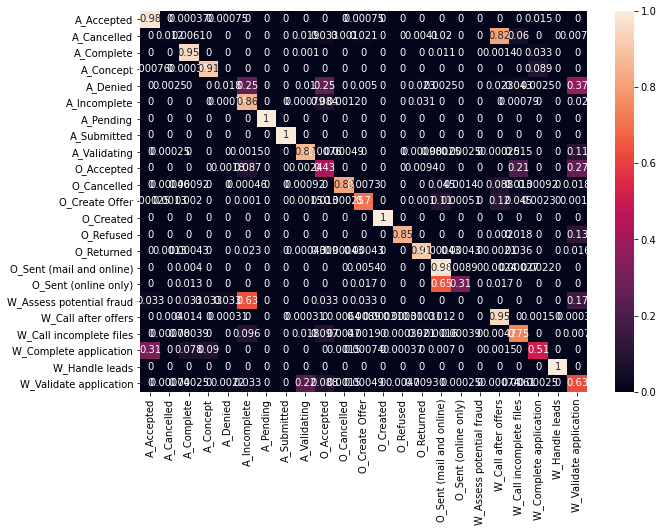

In [58]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
m1_y_pred
m2_y_test = y_test.argmax(axis=1)
m2_y_pred = y_pred.argmax(axis=1)

,y_test,m1_y_pred,m2_y_pred
0,8,21,21
1,8,21,21
2,20,20,20
3,6,6,6
4,18,18,18
...,...,...,...
17272,13,13,13
17273,14,14,14
17274,20,20,20
17275,5,5,5


In [61]:
import scipy.stats as stats
stats.ttest_ind(st['m1_y_pred'], st['m2_y_pred'])

Ttest_indResult(statistic=1.4544703326592676, pvalue=0.1458250365364149)

In [60]:
st.to_csv("st.csv")